<a href="https://colab.research.google.com/github/mnmahir/best-fyp/blob/main/System_web_app_(backend).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install anvil-uplink
import anvil.server
import anvil.media
# Google Drive
from google.colab import drive
# General
import math
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
!pip install image_slicer
import os
import glob
import image_slicer
# Keras Library
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, load_img
# Others
import os

     |████████████████████████████████| 61kB 3.0MB/s 
     |████████████████████████████████| 61kB 4.1MB/s 
  Created wheel for ws4py: filename=ws4py-0.5.1-cp36-none-any.whl size=45216 sha256=3d9bb7a3180d6e59abb2e1cb4941d7d04a8f958a366b06934ab8c6f8aa3d9cca
  Stored in directory: /root/.cache/pip/wheels/a2/6e/4e/8b0ae12fb9b8a05715256952cf7609a8ab86285fab99b88c68
Successfully built ws4py


     |████████████████████████████████| 2.2MB 4.3MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [5]:
from google.colab import drive
drive.mount('/content/gdrive')
model = tf.keras.models.load_model('/content/gdrive/MyDrive/FYP Stuff/Model/DenseNet201_All_Stain_Model.h5')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
###########################
# Initialization
###########################
IMAGE_CLASSES = ['NORMAL','GRADE 1','GRADE 2','GRADE 3']
IMAGE_WIDTH,IMAGE_HEIGHT = (224,224)
sliced_img_path = '/content/sliced_img'
try: 
  os.mkdir(sliced_img_path) # For before calling slice
except:
  print("Folder already created")



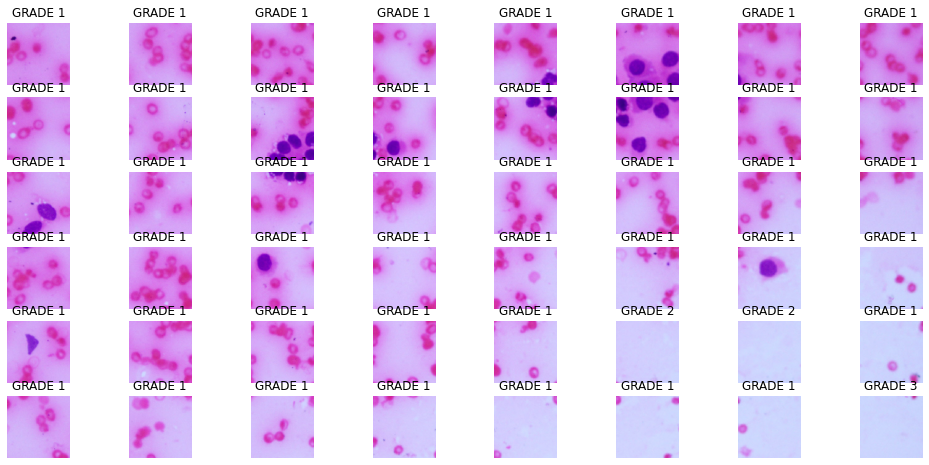

In [30]:
#####################################
# Slice image / remove sliced images
#####################################
#To be called before making prediction
def slice_image(ori_img, srow = 6, scol = 8): #later add row and col
  os.chdir(sliced_img_path)

  ori_img.save('ori.png')
  image_slicer.slice('ori.png', row = srow, col = scol)
  os.remove('ori.png') #Delete original image
  os.chdir('/content')

# To be called after done with prediction and calculation
def remove_sliced_images():
  files = glob.glob(sliced_img_path+'/*')  
  for f in files:
      os.remove(f)                      # Delete everything in folder

# Get slicing parameter (200px)
def get_slice_param(img):
  img_width, img_height = img.size
  swidth = int(img_width/200) #To get 200px
  sheight = int(img_height/200)
  owidth = int(img_width/swidth)
  oheight = int(img_height/sheight)
  return swidth, sheight, owidth, oheight

#####################################
# Make prediction (Will predict all images in the "sliced_img" folder)
#####################################
def get_predictions():
  predictions = []
  for i,img in enumerate(sorted(os.listdir(sliced_img_path))):
    img = os.path.join(sliced_img_path, img)
    img = image.load_img(img, target_size=(IMAGE_WIDTH,IMAGE_HEIGHT))
    arr = image.img_to_array(img)
    arr = np.expand_dims(arr, axis=0)
    arr /= 255
    predictions.append(model.predict(arr))
  pred_labels = np.argmax(predictions, axis=-1)
  return predictions, pred_labels

############################
# Save all prediction patches
############################
def save_predicted_patches(pred_labels, srow = 6, scol = 8):
  imeg_freq = len(pred_labels)
  disp_row = srow
  plt.figure(1, figsize = (scol*1.9, srow*2.2))
  for j,img in enumerate(sorted(os.listdir(sliced_img_path))):
    img = image.load_img(os.path.join(sliced_img_path,img), target_size=(IMAGE_WIDTH,IMAGE_HEIGHT))
    title = str(IMAGE_CLASSES[pred_labels[j][0]])
    plt.subplot(srow, scol, j+1)
    plt.title(title)
    plt.axis('off')
    plt.imshow(img)

  #plt.show()
  plt.savefig('predicted_patches.png', bbox_inches='tight', pad_inches = 0)

In [24]:
anvil.server.connect("L3PK5MYQVJ4ZK5FTWKPZYKUD-FBM5VHPXV3N7HNS4")
@anvil.server.callable
def predict_click(img_file):
  global image_received, score
  with anvil.media.TempFile(img_file) as filename:
    img = load_img(filename)
  swidth, sheight, owidth, oheight = get_slice_param(img)
  slice_image(img, srow = sheight, scol = swidth)
  predictions, pred_labels = get_predictions()
  save_predicted_patches(pred_labels, srow = sheight, scol = swidth)
  remove_sliced_images()

  send_image = anvil.media.from_file('predicted_patches.png', '/content/') #To convert into anvil media object (filename, path)
  return 'TEST', send_image

# Debug Code

In [23]:
swidth, sheight = get_slice_param(image_received)

ValueError: ignored

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1600x1200 at 0x7FA038FA6780>
[[5.3656901e-19 1.0000000e+00 1.6977966e-11 8.6340694e-15]]
Folder already created
Size:  (1600, 1200)


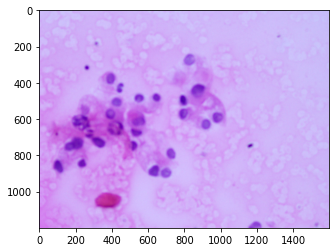

In [9]:
# Run after click predict in anvil
print(image_received)
plt.imshow(image_received)
plt.savefig('test.png')
print(score)
a = get_label(score)
#print (IMAGE_CLASSES[a[0]])
slice_image(image_received)
print('Size: ',image_received.size)
